## Electricty Load Forecasting

In [1]:
import os
os.listdir()

['RO_2024.csv',
 'RO_2025.csv',
 '.ipynb_checkpoints',
 'RO_2023.csv',
 'electricity_forecast.ipynb',
 '.git']

### Data Loading
**Source:** https://transparency.entsoe.eu/

The data used represents the quarter-hourly electricity load data for Romania (years 2023-2025) and it was obtained from the ENTSO-E Transparency Platform, the official data portal of the European Network of Transmission System Operators for Electricity

In [2]:
import pandas as pd

df_2023 = pd.read_csv("RO_2023.csv")
df_2024 = pd.read_csv("RO_2024.csv")
df_2025 = pd.read_csv("RO_2025.csv")
df = pd.concat([df_2023,df_2024,df_2025], ignore_index = True)
print("Rows and columns:", df.shape)
df.head()

Rows and columns: (105216, 4)


,MTU (CET/CEST),Area,Actual Total Load (MW),Day-ahead Total Load Forecast (MW)
0,01/01/2023 00:00 - 01/01/2023 00:15,Romania (RO),5074.0,5310.0
1,01/01/2023 00:15 - 01/01/2023 00:30,Romania (RO),5016.0,5220.0
2,01/01/2023 00:30 - 01/01/2023 00:45,Romania (RO),4963.0,5150.0
3,01/01/2023 00:45 - 01/01/2023 01:00,Romania (RO),4910.0,5090.0
4,01/01/2023 01:00 - 01/01/2023 01:15,Romania (RO),4881.0,5030.0


### Data Preprocessing

In [3]:
df["start_time_str"] = df["MTU (CET/CEST)"].str.split(" - ").str[0]
df[["MTU (CET/CEST)","start_time_str"]].head()

,MTU (CET/CEST),start_time_str
0,01/01/2023 00:00 - 01/01/2023 00:15,01/01/2023 00:00
1,01/01/2023 00:15 - 01/01/2023 00:30,01/01/2023 00:15
2,01/01/2023 00:30 - 01/01/2023 00:45,01/01/2023 00:30
3,01/01/2023 00:45 - 01/01/2023 01:00,01/01/2023 00:45
4,01/01/2023 01:00 - 01/01/2023 01:15,01/01/2023 01:00


In [4]:
df.loc[
    df["MTU (CET/CEST)"].str.contains("CET|CEST"),
    ["MTU (CET/CEST)", "start_time_str"]
].sample(3, random_state = 1)

,MTU (CET/CEST),start_time_str
98790,26/10/2025 02:30 (CEST) - 26/10/2025 02:45 (CEST),26/10/2025 02:30 (CEST)
98794,26/10/2025 02:30 (CET) - 26/10/2025 02:45 (CET),26/10/2025 02:30 (CET)
98788,26/10/2025 02:00 (CEST) - 26/10/2025 02:15 (CEST),26/10/2025 02:00 (CEST)


In [5]:
df["start_time_str"] = df["start_time_str"].str.replace(r" \(CET\)| \(CEST\)","", regex = True)
df["start_time"] = pd.to_datetime(df["start_time_str"], dayfirst = True)
df[["start_time_str","start_time"]].head()    

,start_time_str,start_time
0,01/01/2023 00:00,2023-01-01 00:00:00
1,01/01/2023 00:15,2023-01-01 00:15:00
2,01/01/2023 00:30,2023-01-01 00:30:00
3,01/01/2023 00:45,2023-01-01 00:45:00
4,01/01/2023 01:00,2023-01-01 01:00:00


In [6]:
df = df.set_index("start_time")
df.index[:5]

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 00:15:00',
               '2023-01-01 00:30:00', '2023-01-01 00:45:00',
               '2023-01-01 01:00:00'],
              dtype='datetime64[ns]', name='start_time', freq=None)

In [7]:
df["Actual Total Load (MW)"] = pd.to_numeric(df["Actual Total Load (MW)"], errors = "coerce")
df["Day-ahead Total Load Forecast (MW)"] = pd.to_numeric(df["Day-ahead Total Load Forecast (MW)"], errors="coerce")
df[["Actual Total Load (MW)","Day-ahead Total Load Forecast (MW)"]].dtypes

Actual Total Load (MW)                float64
Day-ahead Total Load Forecast (MW)    float64
dtype: object

The quarter-hourly values are aggregated into hourly loads in order to better inform the subsequent predictive model.

The ENTSO-E data provides power (measured in MegaWatts), which represents the rate at which electricity is being consumed, hence the appropriate way to aggregate quarter-hourly values to hourly is by computing the mean average for said hour.

In [8]:
hourly = df[["Actual Total Load (MW)","Day-ahead Total Load Forecast (MW)"]].resample("h").mean()
hourly.head()

,Actual Total Load (MW),Day-ahead Total Load Forecast (MW)
start_time,,
2023-01-01 00:00:00,4990.75,5192.5
2023-01-01 01:00:00,4814.50,4967.5
2023-01-01 02:00:00,4663.75,4787.5
2023-01-01 03:00:00,4566.75,4630.0
2023-01-01 04:00:00,4520.75,4580.0


In [9]:

hourly.index.min(), hourly.index.max(), hourly.shape

(Timestamp('2023-01-01 00:00:00'),
 Timestamp('2025-12-31 23:00:00'),
 (26304, 2))

### Feature Engineering

Proposed **features**, given an **hour t**: 
- load(t-1),...,load(t-24)
- load(t-168) (same hour last week)
- F(t) (operator's forecast for hour t, **Day-ahead Total Load Forecast (MW)**)
- hour_sin = sin(2$\pi \times$ hour / 24) (to better capture the cyclical nature of the hours, e.g. 23:00 and 00:00 are closer than a linear representation would otherwise suggest)
- hour_cos = cos(2$\pi \times$ hour / 24)
- day of the week
- month
- $\Delta_{1}$ = load(t-1) - load(t-2)
- $\Delta_{24}$ = load(t-1) - load(t-25)

**Target**: A(t) (**Actual Total Load (MW)**)

In [10]:
import numpy as np

data = hourly.copy()
data = data.rename(columns={
    "Actual Total Load (MW)": "load",
    "Day-ahead Total Load Forecast (MW)": "forecast"
})

# Calendar features
data["hour"] = data.index.hour
data["day_of_week"] = data.index.dayofweek
data["month"] = data.index.month

# Cyclical encoding of hours
data["hour_sin"]= np.sin(2*np.pi*data["hour"] /24)
data["hour_cos"]= np.cos(2*np.pi*data["hour"] /24)

# Lag Features
for lag in range(1,25):
    data[f"lag_{lag}"] = data["load"].shift(lag)

# Same hour last week
data["lag_168"] = data["load"].shift(168)

# Difference features
data["delta_1"] = data["load"].shift(1) - data["load"].shift(2)
data["delta_24"] = data["load"].shift(1) - data["load"].shift(25)

# Target
data["target"] = data["load"]

# Only keep rows with full history
data = data.dropna()

# Final feature set
feature_cols = (
    [f"lag_{i}" for i in range (1,25)] +
    ["lag_168", "forecast",
     "hour_sin", "hour_cos",
     "day_of_week", "month",
     "delta_1", "delta_24"]
)

X = data[feature_cols]
y = data["target"]

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

Feature matrix shape: (26022, 32)
Target vector shape: (26022,)


### Train/Test Split

In [11]:
train_mask = X.index < "2025-01-01"
test_mask = X.index >= "2025-01-01"

X_train = X.loc[train_mask]
X_test = X.loc[test_mask]

y_train = y.loc[train_mask]
y_test = y.loc[test_mask]

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (17322, 32) (17322,)
Test shape: (8700, 32) (8700,)


### Model training and evaluation

Baseline: Day-ahead Total Load Forecast (MW)

Evaluation: MAE (Mean Absolute Error) and RMSE (Root Mean Squared Error)

In [12]:
import sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Baseline: operator's forecast as-is
y_pred_op = X_test["forecast"]

# Evaluate baseline with MAE and RMSE
mae_op = mean_absolute_error(y_test, y_pred_op)
rmse_op = np.sqrt(mean_squared_error(y_test, y_pred_op))

print("Operator forecast baseline")
print("MAE: ", mae_op)
print("RMSE: ", rmse_op)

Operator forecast baseline
MAE:  122.15205239463603
RMSE:  177.0350235712765


#### Linear Regression

In [13]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression()
lin.fit(X_train, y_train)

y_pred_lin = lin.predict(X_test)

mae_lin = mean_absolute_error(y_test, y_pred_lin)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))

print("Linear Regression")
print("MAE: ", mae_lin)
print("RMSE: ", rmse_lin)


Linear Regression
MAE:  66.89403005788398
RMSE:  91.35135013422831


#### Multilayer Perceptron Regressor

In [14]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(
    hidden_layer_sizes=(64,32),
    activation="relu",
    max_iter=500,
    random_state=13
)

mlp.fit(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)

mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
rmse_mlp = np.sqrt(mean_squared_error(y_test, y_pred_mlp))

print("Multilayer Perceptron Regressor")
print("MAE: ", mae_mlp)
print("RMSE: ",rmse_mlp)

Multilayer Perceptron Regressor
MAE:  63.05379804518097
RMSE:  83.14793981818899


#### MLP with StandardScaler
Features lie on unbalanced scales: loads, lags, forecasts are around 4000-9000 MW, while hour_sin and hour_cos are between -1 and 1, and day_of_week and month are small integers.

As a neural network learns by adjusting weights, the features with greater values will end up dominating the gradient updates during training, hindering effective learning from smaller-scale features.

StandardScaler fixes this by transforming every feature into: $x_{scaled} = \frac{x - mean}{std}$

After scaling each feature will have mean = 0 and standard deviation (std) = 1.

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

mlp_scaled = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(64,32),
        activation = "relu",
        max_iter=1000,
        random_state=13
    ))
])

mlp_scaled.fit(X_train, y_train)
y_pred_mlp_scaled = mlp_scaled.predict(X_test)

mae_mlp_scaled = mean_absolute_error(y_test, y_pred_mlp_scaled)
rmse_mlp_scaled = np.sqrt(mean_squared_error(y_test, y_pred_mlp_scaled))

print("Scaled MLP")
print("MAE: ", mae_mlp_scaled)
print("RMSE: ", rmse_mlp_scaled)

Scaled MLP
MAE:  54.155541285856124
RMSE:  72.99532463409066


#### Further adjustments

In [16]:
mlp_scaled_adjusted = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(128, 64, 32),
        activation = "relu",
        max_iter=2000,
        alpha=1e-3,
        early_stopping = True,
        n_iter_no_change=20,
        random_state=13
    ))
])

mlp_scaled_adjusted.fit(X_train, y_train)
y_pred_mlp_scaled_adjusted = mlp_scaled_adjusted.predict(X_test)

mae_mlp_scaled_adjusted = mean_absolute_error(y_test, y_pred_mlp_scaled_adjusted)
rmse_mlp_scaled_adjusted = np.sqrt(mean_squared_error(y_test, y_pred_mlp_scaled_adjusted))

print("Scaled MLP")
print("MAE: ", mae_mlp_scaled_adjusted)
print("RMSE: ", rmse_mlp_scaled_adjusted)

Scaled MLP
MAE:  56.783137207219816
RMSE:  75.66342696001664


### Results

In [17]:
results = pd.DataFrame({
    "Model": ["Baseline: Operator Forecast", "Linear regression", "Multilayer Perceptron", "MLP + StandardScaler"],
    "MAE (MW)": [mae_op, mae_lin, mae_mlp, mae_mlp_scaled],
    "RMSE (MW)": [rmse_op,rmse_lin,rmse_mlp,rmse_mlp_scaled] 
})

results

,Model,MAE (MW),RMSE (MW)
0,Baseline: Operator Forecast,122.152052,177.035024
1,Linear regression,66.894030,91.351350
2,Multilayer Perceptron,63.053798,83.147940
3,MLP + StandardScaler,54.155541,72.995325


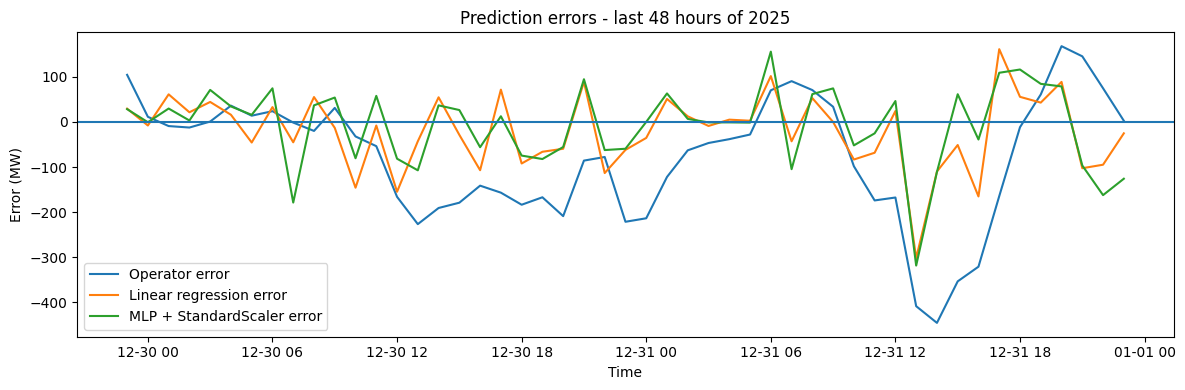

In [22]:
import matplotlib.pyplot as plt

end_date = X_test.index.max()
start_date = end_date - pd.Timedelta(hours=48)

mask = (X_test.index >= start_date) & (X_test.index <= end_date)

X_vis = X_test.loc[mask]
y_vis = y_test.loc[mask]

y_op_vis = X_vis["forecast"]
y_lin_vis = lin.predict(X_vis)
y_mlp_vis = mlp_scaled.predict(X_vis)

err_op = y_op_vis - y_vis
err_lin = y_lin_vis - y_vis
err_mlp = y_mlp_vis - y_vis

plt.figure(figsize=(12,4))
plt.plot(y_vis.index, err_op, label="Operator error")
plt.plot(y_vis.index, err_lin, label="Linear regression error")
plt.plot(y_vis.index, err_mlp, label="MLP + StandardScaler error")
plt.axhline(0)
plt.title("Prediction errors - last 48 hours of 2025")
plt.xlabel("Time")
plt.ylabel("Error (MW)")
plt.legend()
plt.tight_layout()
plt.show()